# Create Climate Network of monthly 2m temperature from ERA5


In [1]:
import numpy as np
import climnet.datasets.dataset as cds
import climnet.network.net as net
import climnet.network.clim_networkx as cn
import geoutils.utils.time_utils as tut
import geoutils.plotting.plots as gplt
from importlib import reload

# Set parameters and paths
datapath = '/home/strnad/data/climnet/outputs/climate_data/'
datafile = f'{datapath}/era5_t2m_2.5_ds.nc'

### Regridding of data to an equidistant grid
The data is interpolated to an (approximately) uniformly spaced Fekete Grid.

The dataset class will also create anomaly time series of the input time series with respect to day of year.

Moreover, the data is detrended.

In [2]:
reload(cds)
ds = cds.BaseDataset(data_nc=datafile,
                     var_name='t2m',
                     grid_step=5,
                     grid_type='fekete',
                     detrend=True,
                     can=True,
                     an_types=["dayofyear"])


Sort longitudes and latitudes in ascending order, respectively
Start create grid fekete...
Try to load grid None...

Create Fekete grid with 1483 points with 1000 iterations.
Initial configuration not provided. Generating random one ...


Estim100%|██████████████████████████████| 1000/1000 [01:31<00:00, 10.93it/s]

... Finished
Cut grid in range lat: [array(-90.), array(90.)] and lon: [array(-180.), array(179.75)]
transpose data!



Intpo100%|██████████████████████████████| 14975/14975 [01:52<00:00, 133.33it/s]


Detrending data...
... finished!
Created dayofyearly anomalies!
Rename t2m to t2m_an_dayofyear!
Init the point-idx dictionaries


In [3]:
ds.set_var('an_dayofyear')

Set variable name to an_dayofyear!


### Create a network from the created dataset

Here we create a network based on spearman correlations where we create the network only for correlation values with highest/lowest correlation such that the density of the network is 2%.

In [4]:
reload(cn)
Net = cn.Clim_NetworkX(dataset=ds)
# Create Correlation Climnet
corr_method = 'spearman'
sig_test = 'twosided'
post_hoc = 'standard'
density = 0.05
threshold = None
weighted = True

Net.create(method='corr',
           corr_method=corr_method,
           stat_test=sig_test,
           confidence=0.99,
           significance_test=post_hoc,
           threshold=threshold,
           density=density,
           weighted=weighted,
           )


Create Network based on method corr
(14975, 1482)
Created spearman correlation matrix of shape (1482, 1482)
Minimum Correlation values: 0.13816333798066838
Created adjacency matrix.
No isolated nodes anymore!
Set Edge correlation!


100%|██████████| 1482/1482 [00:00<00:00, 2030.64it/s]


Finished setting edge corr values!
DiGraph with 1482 nodes and 109816 edges
Sparsity of adjacency:0.04999990893875403
Node attributes: ['lon', 'lat']
Edge attributes: ['weight', 'corr']


We remove spurious links using link bundling. This may take a while. Therefore, we suggest to store the network after that.

Currently, we create a networkx object from the computed network to store computed properties

### Plot node degree

Compute degree, weighted=False!
Compute degree, weighted=True!
Compute Weighted Node degree...
Create ds for all attributes present in node 0.
Create ds for all attributes present in node 0.


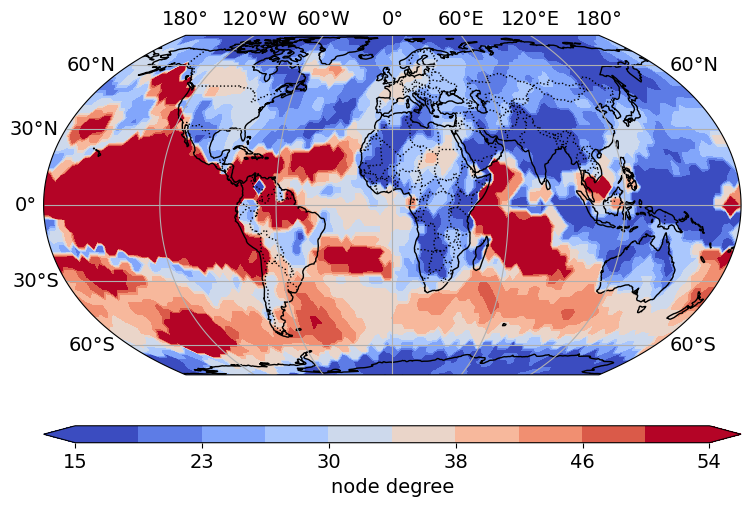

In [5]:
reload(gplt)
Net.compute_network_attrs('degree')
Net.create_ds()
im = gplt.plot_map(Net.ds_nx['weighted_degree'],
                   plot_type='contourf',
                   projection='EqualEarth',
                   plt_grid=True,
                   levels=10,
                   tick_step=2,
                   round_dec=0,
                   label='node degree',
                   )
